In [7]:
import matplotlib.pyplot as plt
import numpy as np
import itertools
from matplotlib import cm

import imageio
import os

#%matplotlib widget
plt.style.use('dark_background')

In [8]:
# angular coordinates transformtion to x,y mollewide coordinates
def ang_to_mollweide(phi,theta):   
    x = phi / np.pi * np.sqrt(1 - (theta / (np.pi / 2)) ** 2)
    y = theta / np.pi
    return x,y

In [9]:
# uniformly distributed random points
def rand_sphere(npt):
    phi=np.random.uniform(-np.pi,np.pi,npt)
    theta=np.arccos(np.random.uniform(-1,1,npt))-np.pi/2
    pos = np.vstack((phi,theta)).T
    return pos

In [10]:
# initialize positions (uniform) and velocities (zeros)
def init_dof(npt):
    pos = rand_sphere(npt)
    vel = np.zeros_like(pos)
    return pos, vel

In [96]:
# measure the great-circle distance between points
def dist_on_sphere(particles,pos=[0,0]):
    dlambda = np.array(particles[0]) - pos[0]
    return np.arccos((np.sin(particles[1])*np.sin(pos[1]) + np.cos(particles[1])*np.cos(pos[1])*np.cos(dlambda))*0.99999999)

In [97]:
# plot points on 2D plane using mollweide projection
def mollweide_plot(pos):
    fig = plt.figure(dpi=150)
    ax = fig.add_subplot(111)
    ax.axis("equal")
    ax.axis(False)

    pos_moll=ang_to_mollweide(pos.T[0],pos.T[1])
    ax.plot(pos_moll[0],pos_moll[1],".",color="white",markersize=1)

    x=np.linspace(-1,1,1001)
    contour=np.sqrt(1-x**2)/2
    ax.plot(x,contour,x,-contour,color="white",linewidth=0.5)

    plt.show()

In [98]:
# angular coordinates to 3d xyz coordinates to plot a sphere
def ang_to_xyz(phi,theta):
    x = np.sin(theta+np.pi/2)*np.cos(phi)
    y = np.sin(theta+np.pi/2)*np.sin(phi)
    z = np.cos(theta+np.pi/2)
    return x,y,z

In [99]:
# plot points on a 3D sphere
def graf3D(pos):
    fig = plt.figure(dpi=150)
    ax = fig.add_subplot(111, projection='3d')

    x,y,z = ang_to_xyz(pos.T[0],pos.T[1])

    ax.scatter(x, y, z, marker=".")

    u, v = np.mgrid[0:2*np.pi:30j, 0:np.pi:15j]
    x = 0.99*np.cos(u)*np.sin(v)
    y = 0.99*np.sin(u)*np.sin(v)
    z = 0.99*np.cos(v)
    ax.plot_wireframe(x, y, z, color="w", alpha=0.2)

    ax.axis(False)
    ax.set_box_aspect([1,1,1])

    plt.show()

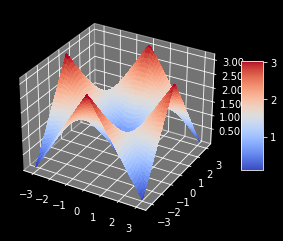

In [100]:
# Great circle distance function surface plotting
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})

phi = np.arange(-np.pi, np.pi, np.pi/48)
theta = np.arange(-np.pi, np.pi, np.pi/48)
phi, theta = np.meshgrid(phi, theta)
d = dist_on_sphere([phi,theta])

surf = ax.plot_surface(phi,theta, d, cmap=cm.coolwarm, linewidth=0, antialiased=False)
ax.zaxis.set_major_formatter('{x:.02f}')
fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()

In [101]:
# Test on great circle distance function
phi = np.arange(-np.pi, np.pi, np.pi/24)
theta = np.arange(-np.pi/2, np.pi/2, np.pi/24)
meshd = np.meshgrid(phi, theta)
phi = np.concatenate(meshd[0])
theta = np.concatenate(meshd[1])

d = dist_on_sphere([phi, theta],[np.pi/2,np.pi/4])

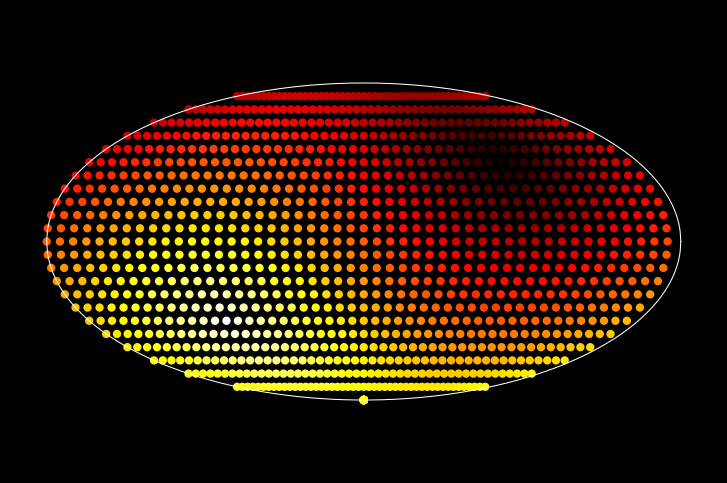

In [102]:
pos_moll = ang_to_mollweide(phi, theta)
fig = plt.figure(dpi=150)
ax = fig.add_subplot(111)
ax.axis("equal")
ax.axis(False)
ax.scatter(pos_moll[0], pos_moll[1], c = d, marker = ".", cmap = cm.hot)
x = np.linspace(-1,1,1001)
contour = np.sqrt(1-x**2)/2
ax.plot(x, contour, x, -contour, color="white", linewidth = 0.5)

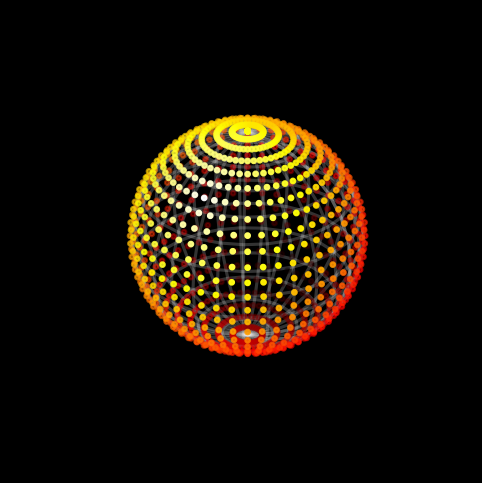

In [103]:
plt.style.use('dark_background')
fig = plt.figure(dpi=150)
ax = fig.add_subplot(111, projection='3d')

x,y,z = ang_to_xyz(phi,theta)

ax.scatter(x, y, z, c = d,cmap = cm.hot , marker=".")

u, v = np.mgrid[0:2*np.pi:30j, 0:np.pi:15j]
x = 0.99*np.cos(u)*np.sin(v)
y = 0.99*np.sin(u)*np.sin(v)
z = 0.99*np.cos(v)
ax.plot_wireframe(x, y, z, color="w", alpha=0.2)

ax.axis(False)
ax.set_box_aspect([1,1,1])

plt.show()

In [104]:
def g_at_pos_ang(pos, particles, mass, epsilon=1.0, doimages=True):
    
    ang_dist = dist_on_sphere(particles.T, pos)
    
    delta_r = particles - pos
    for i in range(len(delta_r)):
        if(np.absolute(delta_r[i][0]) > np.pi):
            delta_r[i][0] = (-1)*np.sign(delta_r[i][0])*(2*np.pi - np.absolute(delta_r[i][0]))
        # if(delta_r[i][0] != 0 and delta_r[i][1] != 0):
        #     delta_r[i][0] = delta_r[i]
        #     delta_r[i] = delta_r[i]/np.sqrt(delta_r[i][0]**2 + delta_r[i][1]**2)

    result  = mass * np.sum(delta_r.T / (ang_dist + epsilon)**3,axis=1)
    
    delta_r_image = np.array((delta_r.T[0] - np.sign(delta_r.T[0])*2*np.pi ,delta_r.T[1] - np.sign(delta_r.T[1])*np.pi)).T
    ang_dist_image = 2 * np.pi - ang_dist
    firstimage = mass * np.sum(delta_r_image.T / (ang_dist_image + epsilon)**3,axis=1)
    
    result += firstimage
    
    # IMAGES NOT READY
    if doimages:

        shift  = np.array([-2*np.pi, 0, 2*np.pi])
        images = []

        for triple in itertools.product(shift, repeat=2):
            images.append(triple)
    
        images.remove((0, 0))
    
        images = np.array(images)
    
        for image in images:
            delta_r_displaced = delta_r = dist_on_sphere(particles - pos + image)
            result += mass * delta_r_displaced / (delta_r_displaced**2. + epsilon**2.)**(3./2.)

    return  result

Gravitational field on [-1.5707963267948966, 0]:
[2.73628506e-06 0.00000000e+00]


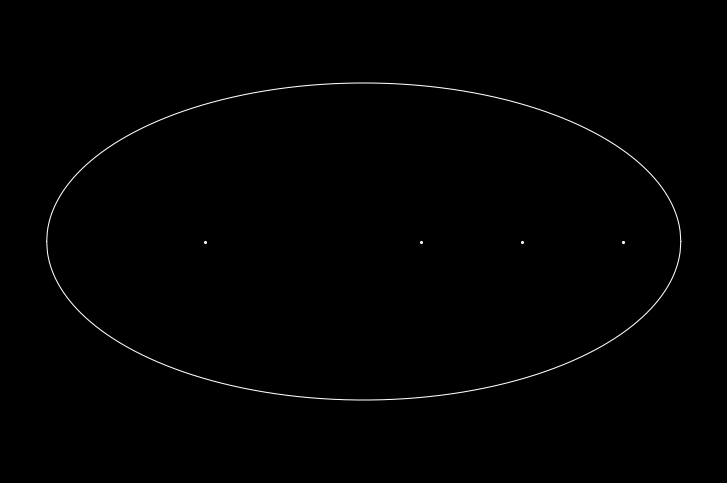

In [105]:
# Testing g_at_pos_ang function
particles = np.array([[np.pi/2,0],[np.pi/2+1,0],[np.pi/2-1,0]])
test = [-np.pi/2,0]

g = g_at_pos_ang(test,particles,0.1,0.0001,doimages=False)

print("Gravitational field on " + str(test) + ":\n" + str(g))

all = np.concatenate((particles,[test]))
mollweide_plot(all)

In [106]:
# We'll sample the equations of motion in discrete time steps. 
dt         = 5e-3
nsteps     = 800
timesteps  = np.linspace(0, (nsteps)*dt, nsteps, endpoint=False)

# Number and mass of particles
npt        = 100
mass       = 1

# Whether to draw arrows for the acceleration and velocity
draw_acc   = False
draw_vel   = False

# A small drag term to simulate the real drag dark matter particles experience due to the expanding universe
drag = 1e-2

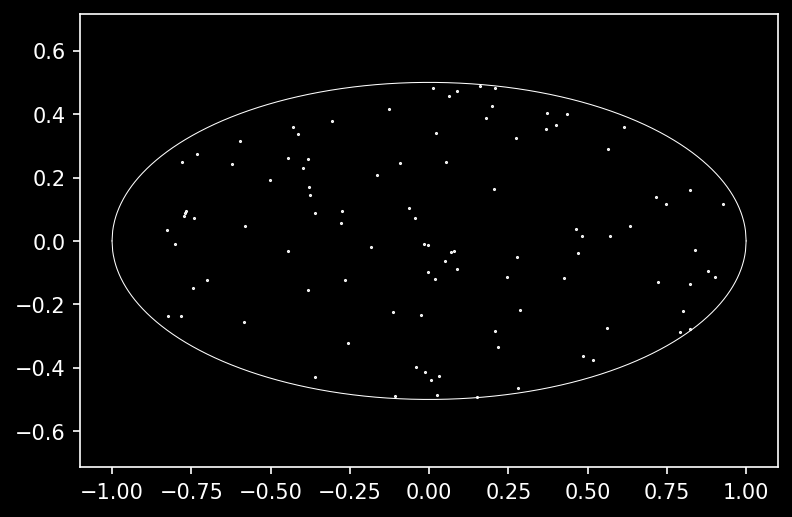

In [107]:
#fig, ax = plt.subplots(1,1, figsize=(5,5), dpi=150)

fig = plt.figure(dpi=150)
ax = fig.add_subplot(111)

# Reinitialise particles.
pos, vel = init_dof(npt=npt)
#mollweide_plot(pos)

#pos = np.array([[np.pi/2,0],[np.pi/2+1,0],[np.pi/2-1,0]])

##
filenames = []
i=0
##

x = np.linspace(-1,1,1001)
contour = np.sqrt(1-x**2)/2


for index_in_timestep, time in enumerate(timesteps):
    dvel = np.zeros_like(vel)
    dpos = np.zeros_like(pos)
    acc = np.zeros_like(pos)
    
    for index_in_particle in range(npt):
        acc[index_in_particle] = g_at_pos_ang(pos[index_in_particle], pos, mass, epsilon=0.1, doimages=False)
        
        # Update velocities. 
        dvel[index_in_particle] = dt * acc[index_in_particle]

        # Update positions.
        dpos[index_in_particle] = dt * vel[index_in_particle]           

    #vel += dvel - drag*vel
    vel += dvel
    pos += dpos

    # Our simulation has periodic boundaries, if you go off one side you come back on the other!
    for k in range(npt):
        if(np.absolute(pos.T[0][k]) / (np.pi) > 1):
            pos.T[0][k] = (pos.T[0][k] + np.pi) % (2*np.pi) - np.pi
        if(np.absolute(pos.T[1][k]) / (np.pi/2) > 1):
            vel.T[1][k] = -vel.T[1][k]
            pos.T[0][k] = pos.T[0][k] + np.pi
            pos.T[0][k] = (pos.T[0][k] + np.pi) % (2*np.pi) - np.pi
            pos.T[1][k] = np.sign(pos.T[1][k])*np.pi - pos.T[1][k]    
    
    ax.axis("equal")
    ax.axis(False)

    pos_moll = ang_to_mollweide(pos.T[0],pos.T[1])
    
    ax.clear()
    
    ax.plot(pos_moll[0],pos_moll[1],".",color="white",markersize=1)
    ax.plot(x,contour,x,-contour,color="white",linewidth=0.5)
    
    #plt.show()
    
    ##
    i+=1
    filename = f'temp_gif_{i}.png'
    filenames.append(filename)
    plt.savefig(filename)
    ##

##
with imageio.get_writer('nbody_sim.gif', mode='I') as writer:
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)
        
# Remove files
for filename in set(filenames):
    os.remove(filename)
##


#mollweide_plot(pos)

    

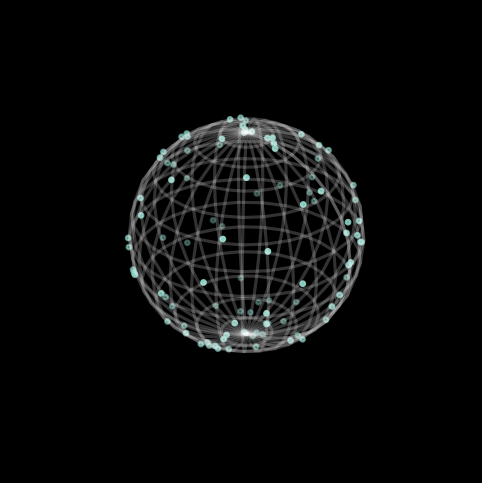

In [108]:
graf3D(pos)